# 3: Feature engineering

## Imports

In [1]:
import os
import sys

sys.path.append("code/.")
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import numpy.random as npr
import pandas as pd
from plotting_functions import *
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

## Outline

- Explain what feature engineering is and the importance of feature engineering in building machine learning models.  
- Carry out preliminary feature engineering on text data. 

## Feature engineering: Motivation

### What is feature engineering?  

- One way to get a better performing model is by hyperparameter tuning. 
- Another way is by changing the input representation. 
- Better representation: more flexibility, higher score, we can get by with simple and more interpretable models. 
- If your features, i.e., representation is bad, whatever fancier model you build is not going to help.

<blockquote>
<b>Feature engineering</b> is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.<br> 
- Jason Brownlee    
</blockquote>    



### Some quotes on feature engineering 

A quote by Pedro Domingos [A Few Useful Things to Know About Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

<blockquote>
... At the end of the day, some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used. 
</blockquote>


A quote by Andrew Ng, [Machine Learning and AI via Brain simulations](https://ai.stanford.edu/~ang/slides/DeepLearning-Mar2013.pptx)

<blockquote>
Coming up with features is difficult, time-consuming, requires expert knowledge. "Applied machine learning" is basically feature engineering.
</blockquote>

### Better features usually help more than a better model.
- Good features would ideally:
    - capture most important aspects of the problem
    - allow learning with few examples 
    - generalize to new scenarios.

- There is a trade-off between simple and expressive features:
    - With simple features overfitting risk is low, but scores might be low.
    - With complicated features scores can be high, but so is overfitting risk.

### The best features may be dependent on the model you use.

- Examples:
    - For counting-based methods like decision trees separate relevant groups of variable values
        - Discretization makes sense 
    - For distance-based methods like KNN, we want different class labels to be "far".
        - Standardization 
    - For regression-based methods like linear regression, we want targets to have a linear dependency on features.

#### Domain-specific transformations

In some domains there are natural transformations to do:
- Spectrograms (sound data)
- Wavelets (image data)
- Convolutions 
<center>
<img src="img/spectogram.png" width="800" height="800">
</center>

[Source](https://en.wikipedia.org/wiki/Spectrogram)

In this notebook we'll focus on the following:   

- Polynomial features (change of basis)
- Radial basis functions (RBFs)
- Two example domains where feature engineering plays an important role:
    - Text data 
    - Audio data

<br><br><br><br>

## Polynomial feature transformations for non-linear regression

### Linear regression example 

- Predicting group size based on the relative size of neocortex. 
- Linear relationship between the brain size and the group size
    - Group size increases with increase in relative neocortex size

<center>
<img src='img/dunbar_number_regression.png' width="600" height="600" />
</center>

[Source](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L13.pdf)

### Linear regression 

- Interested in predicting a scalar valued target (e.g., stock price)
- $\hat{y}$ is the linear function of features $x$ and weights $w$. 

$$\hat{y} = w^Tx + b$$
        
- $\hat{y} \rightarrow$ prediction
- $w \rightarrow$ weight vector
- $b \rightarrow$ bias
- $x \rightarrow$ feature vector
- $w$ and $b$ together are the parameters

$$\hat{y} = \begin{bmatrix}w_1 & w_2 & \cdots & w_d\end{bmatrix}\begin{bmatrix}x_1 \\ x_2 \\ \vdots \\ x_d\end{bmatrix} + b$$


### Linear regression: function 

- Loss function: least squares 
- Find parameters $w$ and $b$ that minimize the squared error between the predicted $\hat{y}$ and true $y$.

$$ f(w) = \frac{1}{2}\sum_{i=0}^{n}{(w^Tx_i - y_i)^2}$$

- 1/2 is for mathematical convenience. 
- Why don't we have a bias term in the above equation (i.e., a y-intercept)?


- Why don't we have a bias term (i.e., a y-intercept)?
  - For simplicity, we rename the bias term as $w_0$ and introduce a dummy feature $x_0$ whose value is always 1. 
  - So $w_0 + w_1x_1 + \dots + w_nx_n$ becomes $w_0x_0 + w_1x_1 + \dots + w_nx_n$, where $x_0$ is always 1. 

### Linear regression: y-intercept

$$ f(w) = \frac{1}{2}\sum_i^{n}{(w^Tx_i - y_i)^2}$$

- Example
    - Suppose $X$ has only one feature, say $x_1$: 
    $$X = \begin{bmatrix}0.86 \\ 0.02 \\ -0.42 \end{bmatrix}$$ 
    - Make a new matrix $Z$ with an extra feature (say $x_0$) whose value is always 1. 
    $$Z = \begin{bmatrix}1 & 0.86\\ 1 & 0.02 \\ 1 & -0.42\\ \end{bmatrix}$$

- Use $Z$ instead of $X$ in linear regression. 
- It learns $w_0$ for this feature, which is the bias term. Since the feature value is always going to be 1 for this feature, the $w_0$ will be added as is when making predictions. 

### Non-linear regression motivation

- Lines and hyperplanes have limited flexibility. 
- Linear regression might seem rather limited, especially in low-dimensional spaces.
- What if the true relationship between the target and the features is non-linear? 
- Can we still use least squares to fit non-linear data? 
- One of the solutions is using feature mappings! 

### Example: Polynomial feature mappings or transforms

- Suppose $X$ has only one feature, say $x_1$
$$X = \begin{bmatrix}0.86 \\ 0.02 \\ -0.42 \end{bmatrix}$$ 


- Our $Z$ will have three features $x_0$, $x_1$, $x_1^2$ with polynomial with degree 2. 
$$Z = \begin{bmatrix}1 & 0.86 & 0.74\\ 1 & 0.02 & 0.0004\\ 1 & -0.42 & 0.18\\ \end{bmatrix}$$

<br> 

- $Z$ $\rightarrow$ augmented dataset with quadratic features
- `fit`: We fit using $Z$ and learn weights $v$. 
- `predict`: When we predict, we need to apply the same transformations on the test example and add these features in the test example and predict using learned weights $v$.

**$\hat{y}$ is a linear function of $v$ and $Z$ but a polynomial function of original features $X$.**

Let's look at a toy example with synthetic data. 

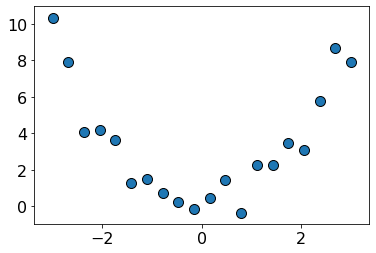

In [2]:
np.random.seed(10)
n = 20
X = np.linspace(-3, 3, n)
y = X ** 2 + npr.randn(n)

# transforming the data to include another axis
X = X[:, np.newaxis]
y = y[:, np.newaxis]

mglearn.discrete_scatter(X[:, 0], y);

- Right now we are focussing on creating a better fit on the training data. So we are skipping splitting the data for demonstration purpose. 
- Also, for simplicity, we are using vanilla `LinearRegression`, which doesn't have any hyperparameter controlling the complexity of the model. 

In [3]:
# Fit a regression line.
lr = LinearRegression()
lr.fit(X, y)
preds = lr.predict(X)

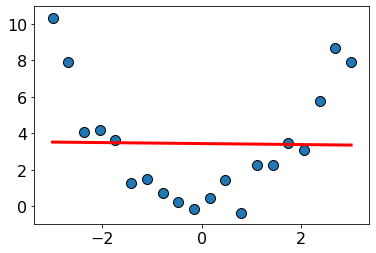

In [4]:
mglearn.discrete_scatter(X[:, 0], y)
plt.plot(X, preds, color="red", linewidth=3);

- Note that the regression line is unable to capture the shape of the data. 
- The model is underfit. 

### Adding polynomial features 

- What if we augment our data by adding interactions and polynomial features?
- For example, we can generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. 
- For one-dimensional feature vector `[a]`, the augmented features with degree 2 polynomial would be: $[1, a, a^2]$. 
- For two-dimensional feature vector `[a, b]`, the augmented features with degree 2 polynomial would be: $[1, a, b, a^2, ab, b^2]$.

- We can do it using [sklearn's PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
- `PolynomialFeatures` is a transformer. 
- Let's try polynomial features with degree 2 and visualize augmented features. 

In [5]:
from sklearn.preprocessing import PolynomialFeatures

deg = 2
poly_feats = PolynomialFeatures(degree=deg)
X_enc = poly_feats.fit_transform(X)
pd.DataFrame(X_enc, columns=poly_feats.get_feature_names_out()).head()

,1,x0,x0^2
0,1.0,-3.000000,9.000000
1,1.0,-2.684211,7.204986
2,1.0,-2.368421,5.609418
3,1.0,-2.052632,4.213296
4,1.0,-1.736842,3.016620


- Let's fit linear regression on the transformed data. 

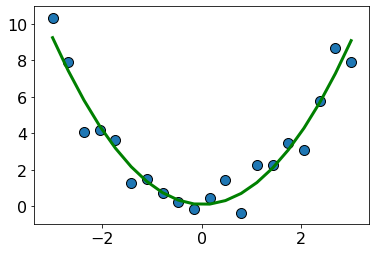

In [6]:
lr_poly = LinearRegression()
lr_poly.fit(X_enc, y)
preds = lr_poly.predict(X_enc)
mglearn.discrete_scatter(X[:, 0], y)
plt.plot(X, preds, color="green", linewidth=3);

Now the fit is much better compared to linear regression on the original data! 

Let's try degree=20 polynomial.

In [7]:
deg = 20
poly_feats = PolynomialFeatures(degree=deg)
X_enc = poly_feats.fit_transform(X)
pd.DataFrame(X_enc, columns=poly_feats.get_feature_names_out()).head(10)

,1,x0,x0^2,x0^3,x0^4,x0^5,x0^6,x0^7,x0^8,x0^9,...,x0^11,x0^12,x0^13,x0^14,x0^15,x0^16,x0^17,x0^18,x0^19,x0^20
0,1.0,-3.000000,9.000000,-27.000000,81.000000,-243.000000,729.000000,-2187.000000,6.561000e+03,-1.968300e+04,...,-1.771470e+05,5.314410e+05,-1.594323e+06,4.782969e+06,-1.434891e+07,4.304672e+07,-1.291402e+08,3.874205e+08,-1.162261e+09,3.486784e+09
1,1.0,-2.684211,7.204986,-19.339700,51.911825,-139.342268,374.023983,-1003.959113,2.694838e+03,-7.233512e+03,...,-5.211735e+04,1.398939e+05,-3.755048e+05,1.007934e+06,-2.705507e+06,7.262150e+06,-1.949314e+07,5.232369e+07,-1.404478e+08,3.769915e+08
2,1.0,-2.368421,5.609418,-13.285464,31.465573,-74.523727,176.503563,-418.034755,9.900823e+02,-2.344932e+03,...,-1.315370e+04,3.115351e+04,-7.378462e+04,1.747531e+05,-4.138888e+05,9.802630e+05,-2.321675e+06,5.498705e+06,-1.302325e+07,3.084454e+07
3,1.0,-2.052632,4.213296,-8.648345,17.751867,-36.438042,74.793875,-153.524271,3.151288e+02,-6.468433e+02,...,-2.725342e+03,5.594124e+03,-1.148268e+04,2.356970e+04,-4.837991e+04,9.930614e+04,-2.038389e+05,4.184062e+05,-8.588338e+05,1.762869e+06
4,1.0,-1.736842,3.016620,-5.239393,9.099999,-15.805262,27.451244,-47.678477,8.280999e+01,-1.438279e+02,...,-4.338741e+02,7.535708e+02,-1.308834e+03,2.273237e+03,-3.948254e+03,6.857494e+03,-1.191038e+04,2.068646e+04,-3.592911e+04,6.240319e+04
5,1.0,-1.421053,2.019391,-2.869660,4.077938,-5.794965,8.234950,-11.702298,1.662958e+01,-2.363151e+01,...,-4.772125e+01,6.781441e+01,-9.636784e+01,1.369438e+02,-1.946043e+02,2.765430e+02,-3.929821e+02,5.584483e+02,-7.935844e+02,1.127725e+03
6,1.0,-1.105263,1.221607,-1.350197,1.492323,-1.649409,1.823031,-2.014930,2.227027e+00,-2.461451e+00,...,-3.006925e+00,3.323444e+00,-3.673280e+00,4.059941e+00,-4.487303e+00,4.959651e+00,-5.481719e+00,6.058742e+00,-6.696505e+00,7.401400e+00
7,1.0,-0.789474,0.623269,-0.492054,0.388464,-0.306682,0.242117,-0.191145,1.509042e-01,-1.191349e-01,...,-7.425304e-02,5.862082e-02,-4.627960e-02,3.653652e-02,-2.884462e-02,2.277207e-02,-1.797795e-02,1.419312e-02,-1.120509e-02,8.846127e-03
8,1.0,-0.473684,0.224377,-0.106284,0.050345,-0.023848,0.011296,-0.005351,2.534611e-03,-1.200605e-03,...,-2.693878e-04,1.276048e-04,-6.044436e-05,2.863154e-05,-1.356231e-05,6.424252e-06,-3.043067e-06,1.441453e-06,-6.827933e-07,3.234284e-07
9,1.0,-0.157895,0.024931,-0.003936,0.000622,-0.000098,0.000015,-0.000002,3.863147e-07,-6.099706e-08,...,-1.520702e-09,2.401109e-10,-3.791224e-11,5.986144e-12,-9.451806e-13,1.492390e-13,-2.356406e-14,3.720641e-15,-5.874696e-16,9.275836e-17


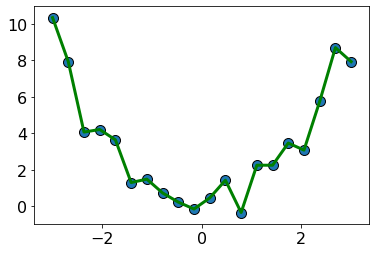

In [8]:
lr_poly = LinearRegression()
lr_poly.fit(X_enc, y)
preds = lr_poly.predict(X_enc)
mglearn.discrete_scatter(X[:, 0], y)
plt.plot(X, preds, color="green", linewidth=3);

- The model is trying to go through every training point. 
- The model is likely to overfit on unseen data.  
- You can pick the degree of polynomial using hyperparameter optimization. 

Also, a good candidate for sklearn pipelines! 

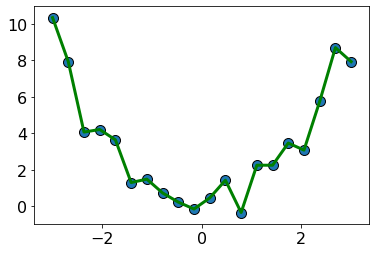

In [9]:
degree = 20
pipe_poly = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())

pipe_poly.fit(X, y)
preds = pipe_poly.predict(X)

mglearn.discrete_scatter(X[:, 0], y)
plt.plot(X, preds, color="green", linewidth=3);

The model has learned coefficients for the transformed features. 

In [10]:
pd.DataFrame(
    pipe_poly.named_steps["linearregression"].coef_.transpose(),
    index=pipe_poly.named_steps["polynomialfeatures"].get_feature_names_out(),
    columns=["Feature coefficients"],
)

,Feature coefficients
1,-0.000346
x0,1.856515
x0^2,9.626527
x0^3,3.763841
x0^4,-31.828365
x0^5,-44.211552
x0^6,29.056499
x0^7,84.271533
x0^8,8.711761
x0^9,-70.499854


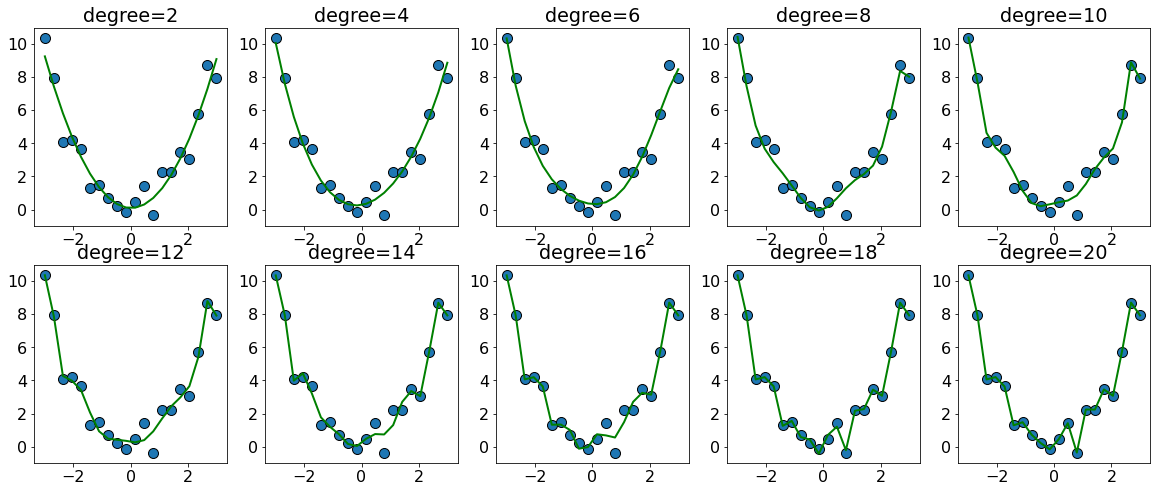

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

degrees = np.arange(2, 21, 2)

for deg, ax in zip(degrees, axes.ravel()):
    pipe_poly = make_pipeline(PolynomialFeatures(degree=deg), LinearRegression())
    pipe_poly.fit(X, y)
    preds = pipe_poly.predict(X)
    mglearn.discrete_scatter(X[:, 0], y, ax=ax)
    ax.plot(X, preds, color="green", linewidth=2)
    title = "degree={}".format(deg)
    ax.set_title(title)

### Questions to consider

How do we know what degree of polynomial to use?
- Can we plot data and see how does it look like so that we can pick polynomial with the appropriate degree?
    - Plotting cannot take us much further
    - Not possible to visualize high dimensional data
- Can we consider one feature at a time?  
    - Hopeless when features interact with each other
    - There is a possibility to draw misleading conclusions when you are only looking at one feature at a time.
- Hyperparameter optimization
    - Can be potentially very slow. 


### Classification setting: Non-linearly separable data 

Is the following dataset (XOR function) linearly separable?  

| $$x_1$$ | $$x_2$$ | target|
|---------|---------|---------|
| 0 | 0  | 0|
| 0 | 1  | 1|
| 1 | 0  | 1|
| 1 | 1  | 0|    

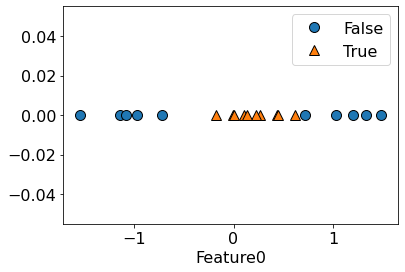

In [12]:
# Consider this one-dimensional classification dataset

n = 20
d = 1
np.random.seed(10)
X = np.random.randn(n, d)
y = np.sum(X ** 2, axis=1) < 0.4
mglearn.discrete_scatter(X[:, 0], np.zeros_like(X), y)
plt.xlabel("Feature0");
plt.legend();

Can we use a linear classifier on this dataset? 

In [13]:
linear_svm = SVC(kernel="linear", C=100)
linear_svm.fit(X, y)
print("Training accuracy", linear_svm.score(X, y))

Training accuracy 0.75


What if we augmented this data with polynomial with degree=2 feature? 

In [14]:
X[:5]

array([[ 1.3315865 ],
       [ 0.71527897],
       [-1.54540029],
       [-0.00838385],
       [ 0.62133597]])

In [15]:
poly = PolynomialFeatures(
    2, include_bias=False
)  # Excluding the bias term for simplicity
X_transformed = poly.fit_transform(X)
X_transformed[0:5]

array([[ 1.33158650e+00,  1.77312262e+00],
       [ 7.15278974e-01,  5.11624011e-01],
       [-1.54540029e+00,  2.38826206e+00],
       [-8.38384993e-03,  7.02889396e-05],
       [ 6.21335974e-01,  3.86058392e-01]])

Training accuracy 1.0


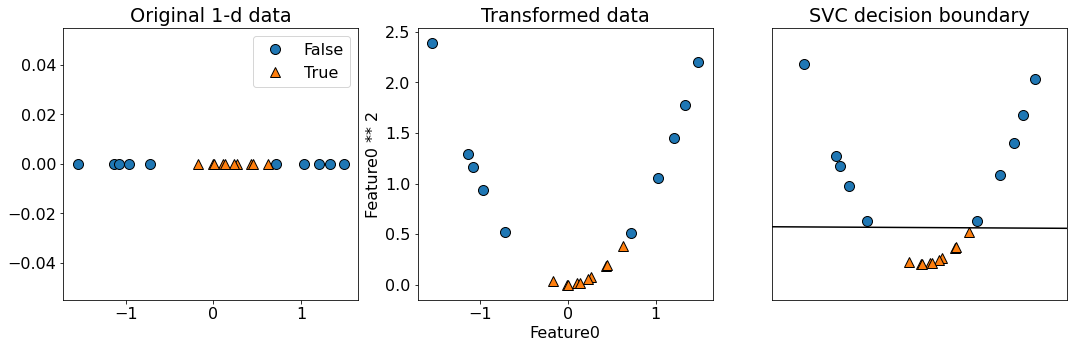

In [16]:
linear_svm = SVC(kernel="linear", C=100)
linear_svm.fit(X_transformed, y)
print("Training accuracy", linear_svm.score(X_transformed, y))
plot_orig_transformed_svc(linear_svm, X, X_transformed, y)

The data is linearly separable in this new feature space!! 

### Another example with two features

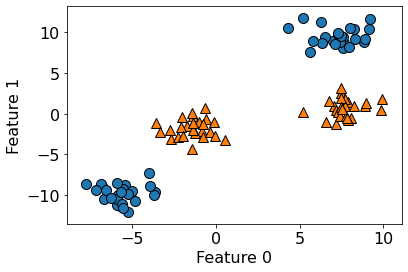

In [17]:
import mglearn
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

/Users/kvarada/opt/miniconda3/envs/573/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


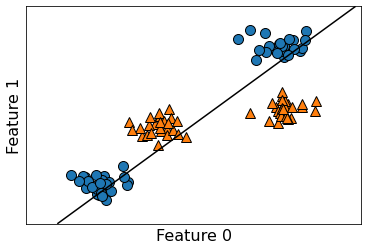

In [18]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

/Users/kvarada/MDS/2021-22/573/DSCI_573_feat-model-select_students/lectures/code/./plotting_functions.py:450: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(figure, elev=-152, azim=-26)


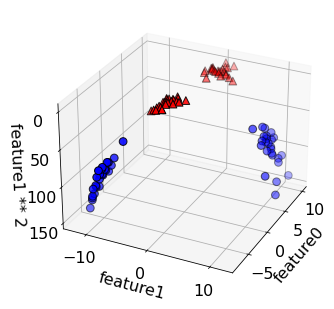

In [19]:
# add the squared second feature
X_new = np.hstack([X, X[:, 1:] ** 2])
plot_mglearn_3d(X_new, y)

/Users/kvarada/opt/miniconda3/envs/573/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kvarada/MDS/2021-22/573/DSCI_573_feat-model-select_students/lectures/code/./plotting_functions.py:414: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(figure, elev=-152, azim=-26)


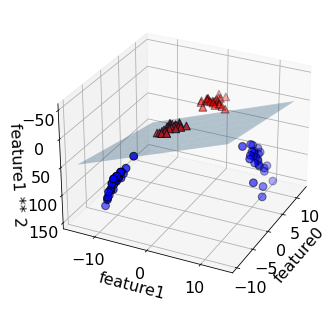

In [20]:
linear_svm_3d = LinearSVC().fit(X_new, y)
XX, YY = plot_svc_3d_decision_boundary(X_new, y, linear_svm_3d)

What does this linear boundary in $Z$-space correspond to _in the original ($X$) space_?

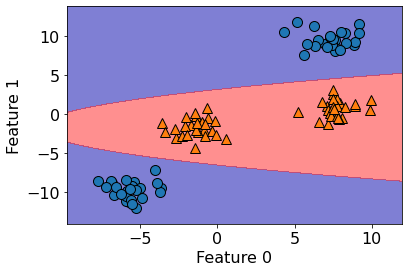

In [21]:
plot_Z_space_boundary_in_X_space(linear_svm_3d, X, y, XX, YY)

It's a parabola!

#### Do XOR-like problems exist in the real world?

- Yes! 
- Consider a simplified sentiment analysis task 
    - **good** $\rightarrow$ positive sentiment
    - **bad** $\rightarrow$ negative sentiment
    - But in the presence of **not** feature the categorization flips
- Similar to non-linear regression, we can deal with XOR-like classification problems by changing features 
    - **not good** $\rightarrow$ negative sentiment
    - **not bad** $\rightarrow$ positive sentiment

<br><br><br><br>

## Radial Basis Functions (RBF)

- The idea of transforming features and creating new features is also referred to as **change of basis**. 

### Problems with polynomial basis 

- Let $d$ be the original number of features and $p$ be the degree of polynomial. 
- In general, we have roughly $O(d^p)$ feature combinations. 
    - For example, for $d = 1000$, and $p = 3$, we would have around a billion new feature combinations! 
- This is problematic! 

### How can we do this efficiently? 

- Kernel trick 
    - Computationally efficient approach to map features
    - Calculate these relationships in higher dimensional space without actually carrying out the transformation.
    
    - Overall, saying something is a "kernel method" correspond to this idea of implicitly calculating relationships in data in higher dimensional space.  
    - Then the different transformations have different names like "polynomial kernel" or "RBF kernel"
    - For details see [this video](https://www.youtube.com/watch?v=mba4xweShwI). 

### RBF Kernel

- Hard to visualize but you can think of this as a weighted nearest-neighbour.
- During prediction, the closest examples have a lot of influence on how we classify the new example compared to the ones further away.
- In general, for both regression/classification, you can think of RBF kernel as "smooth KNN".
- During test time, each training example gets to "vote" on the label of the test point and the amount of vote the $n^{th}$ training example gets is proportional to the the distance between the test point and itself.  

### RBFs

- What is a radial basis function (RBF)?
    - A set of non-parametric bases that depend on distances to training points.
    - Non-parametric because size of basis (number of features) grows with $n$.
- Model gets more complicated as you get more data.

### Example: RBFs 

- Similar to polynomial basis, we transform $X$ to $Z$.
- Consider $X_{train}$ with three examples: $x_1$, $x_2$, and $x_3$ and 2 features and $X_{test}$ with two examples: $\tilde{x_1}$ and $\tilde{x_2}$

$$\text{Transform } X_{train} = \begin{bmatrix} 1 & 0\\ 2 & 1\\ 1 & 2\end{bmatrix} \text{ to } Z_{train} = \begin{bmatrix} g\lVert x_1 - x_1\rVert & g\lVert x_1 - x_2\rVert & g\lVert x_1 - x_3\rVert\\g\lVert x_2 - x_1\rVert & g\lVert x_2 - x_2\rVert & g\lVert x_2 - x_3\rVert\\g\lVert x_3 - x_1\rVert & g\lVert x_3 - x_2\rVert & g\lVert x_3 - x_3\rVert\end{bmatrix}$$  

$$\text{Transform } X_{test} = \begin{bmatrix} 2 & 1\\ 1 & 1 \end{bmatrix} \text{ to } Z_{test} = \begin{bmatrix} g\lVert \tilde{x_1} - x_1\rVert & g\lVert \tilde{x_1} - x_2\rVert & g\lVert \tilde{x_1} - x_3\rVert\\g\lVert \tilde{x_2} - x_1\rVert & g\lVert \tilde{x_2} - x_2\rVert & g\lVert \tilde{x_2} - x_3\rVert\\\end{bmatrix}$$  

- We create $n$ features. 

### Gaussian Radial Basis Functions (Gaussian RBFs)

- Most common $g$ is Gaussian RBF: $$g(\varepsilon)=\exp\left(-\frac{\varepsilon^2}{2\sigma^2}\right)$$

<center>
<img src='img/RBF.png' width="700" height="700" />    
</center>
    
[Source](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L13.pdf)

- So in our case: 
$$g(x_i - x_j)=\exp\left(-\frac{\lVert x_i - x_j\rVert^2}{2\sigma^2}\right)$$
- $\sigma$ is a hyperparameter that controls the width of the bumps. 
- We can fit least squares with different $\sigma$ values


#### Gaussian RBFs (non-parametric basis)

<img src='img/Gaussian_RBF.png' width="700" height="700" />

[source](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L13.pdf)

- How many bumps should we use?
    - We use $n$ bumps (non-parametric basis)
- Where should the bumps be centered?
    - Each bump is centered on one training example $x_i$. 
- How high should the bumps go?
    - Fitting regression weights $w$ gives us the heights (and signs).
- How wide should the bumps be?
    - The width is a hyper-parameter (narrow bumps = complicated model)


- Enough bumps can approximate any continuous function to arbitrary precision.
- But with $n$ data points RBFs have $n$ features
    - How do we avoid overfitting with this huge number of features?
    - We regularize $w$  and use validation error to choose $\sigma$ and $\lambda$.

### Interpretation of `gamma` in SVM RBF

- `gamma` controls the complexity (fundamental trade-off). 
  - larger `gamma` $\rightarrow$ more complex
  - smaller `gamma` $\rightarrow$ less complex
- The `gamma` hyperparameter in SVC is related to $\sigma$ in Gaussian RBF.  
- You can think of `gamma` as the inverse width of the "bumps" 
    - Larger `gamma` means narrower peaks. 
    - Narrower peaks means more complex model. 
    
    
$$g(x_i - x_j)=\exp\left(-\frac{\lVert x_i - x_j\rVert^2}{2\sigma^2}\right)$$    

### Constructing Gaussian RBF with $X$ and $\sigma$

```
Z = zeros(n,n)
for i1 in 1:n
    for i2 in 1:n
        Z(i1,i2) = exp(-(norm(X[i1:] - X[i2:])**2)/(2 * sigma**2)
```

### Gaussian RBFs: Prediction 

- Given a test example $\tilde{x_i}$: 
    
   $$\hat{y_i} = w_1 \exp\left(\frac{-\lVert \tilde{x_i} - x_1\rVert^2}{2\sigma^2}\right) +  w_2 \exp\left(\frac{-\lVert \tilde{x_i} - x_2\rVert^2}{2\sigma^2}\right) + \dots + w_n \exp\left(\frac{-\lVert \tilde{x_i} - x_n\rVert^2}{2\sigma^2}\right)
    = \sum_{j = 1}^n w_j \exp\left(\frac{-\lVert \tilde{x_i} - x_j\rVert^2}{2\sigma^2}\right) $$

- Expensive at test time: needs distance to all training examples.   

### RBF with regulariation and optimized $sigma$ and $\lambda$

- A model that is hard to beat:
    - RBF basis with L2-regularization and cross-validation to choose $\sigma$ and $\lambda$.
    - Flexible non-parametric basis, magic of regularization, and tuning for test error
- For each value of $\lambda$ and $sigma$ 
    - Compute $Z$ on training data
    - Compute best weights $V$ using least squares 
    - Compute $\tilde{Z}$ on validation set (using train set distances)
    - Make predictions $\hat{y} = \tilde{Z}v$
    - Compute validation error 

#### Using RBF with least squares: [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) (optional)
> sklearn.kernel_ridge.KernelRidge(alpha=1, kernel='linear', gamma=None, degree=3, coef0=1, kernel_params=None)

> Kernel ridge regression.
Kernel ridge regression (KRR) combines ridge regression (linear least squares with l2-norm regularization) with the kernel trick. It thus learns a linear function in the space induced by the respective kernel and the data. For non-linear kernels, this corresponds to a non-linear function in the original space.

> The form of the model learned by KRR is identical to support vector regression (SVR). However, different loss functions are used: KRR uses squared error loss while support vector regression uses epsilon-insensitive loss, both combined with l2 regularization. In contrast to SVR, fitting a KRR model can be done in closed-form and is typically faster for medium-sized datasets. On the other hand, the learned model is non-sparse and thus slower than SVR, which learns a sparse model for epsilon > 0, at prediction-time.

<br><br>

## Feature Engineering

- Feature engineering is extremely important but it is domain-specific. 
- So it's hard to talk about general methods for feature engineering. 
- Let's look at examples of what kind of features are relevant in two specific domains: text data and audio data. 

## Common features used in text classification

### Bag of words 

- So far for text data we have been using bag of word features. 
- They are good enough for many tasks. But ... 
- This encoding throws out a lot of things we know about language
- It assumes that word order is not that important.   
- So if you want to improve the scores further on text classification tasks you carry out **feature engineering**. 

Let's look at some examples from research papers.  

### Example: Label "Personalized" Important E-mails: 

- Gmail priority inbox automatically sorts your e-mail by moving the important messages to the top. 
- [The Learning Behind Gmail Priority Inbox](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36955.pdf)
- Features: bag of words, trigrams, regular expressions, and so on.
- There might be some "globally" important messages:
    - "This is your mother, something terrible happened, give me a call ASAP."
- But your "important" message may be unimportant to others.
     - Similar for spam: "spam" for one user could be "not spam" for another.

- Social features (e.g., percentage of sender emails that is read by the recipient)
- Content features (e.g., recent terms the user has been using in emails)
- Thread features (e.g., whether the user has started the thread)
- ...

### [The Learning Behind Gmail Priority Inbox](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36955.pdf)

<center>
<img src="img/gmail_priority_inbox.png" width="1000" height="1000">
</center>    

#### Feature engineering examples: [Automatically Identifying Good Conversations Online](http://www.courtneynapoles.com/res/icwsm17-automatically.pdf)

<center>
<img src="img/classifying_good_conversations_online.png" width="800" height="800">
</center>

### Term weighing (TF-IDF) 

- A measure of relatedness between words and documents
- Intuition: Meaningful words may occur repeatedly in related documents, but functional words (e.g., _make_, _the_) may be distributed evenly over all documents


$$tf.idf(w_i,d_j) = (1+log(tf_{ij})) log\frac{D}{df_i}$$


where, 
- $tf_{ij}$ &rarr; number of occurrences of the term $w_i$ in document $d_j$
- $D$ &rarr; number of documents
- $df_i$ &rarr; number of documents in which $w_i$ occurs

Check `TfidfVectorizer` from `sklearn`. 

### N-grams 

- Incorporating more context 
- A contiguous sequence of _n_ items (characters, tokens) in text.
    <blockquote>
        MDS students are hard-working .
    </blockquote>    

- 2-grams (bigrams): a contiguous sequence of two words
    * _MDS students, students are, are hard-working, hard-working ._
- 3-grams (trigrams): a contiguous sequence of three words
    * _MDS students are, students are hard-working, are hard-working ._

You can extract ngram features using `CountVectorizer` by passing `ngram_range`. 

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

X = [
    "URGENT!! As a valued network customer you have been selected to receive a $900 prize reward!",
    "Lol you are always so convincing.",
    "URGENT!! Call right away!!",
]
vec = CountVectorizer(ngram_range=(1, 3))
X_counts = vec.fit_transform(X)
bow_df = pd.DataFrame(X_counts.toarray(), columns=vec.get_feature_names(), index=X)

/Users/kvarada/opt/miniconda3/envs/573/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
bow_df

,900,900 prize,900 prize reward,always,always so,always so convincing,are,are always,are always so,as,...,urgent call,urgent call right,valued,valued network,valued network customer,you,you are,you are always,you have,you have been
URGENT!! As a valued network customer you have been selected to receive a $900 prize reward!,1,1,1,0,0,0,0,0,0,1,...,0,0,1,1,1,1,0,0,1,1
Lol you are always so convincing.,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,1,1,1,0,0
URGENT!! Call right away!!,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


### ASIDE: [Google n-gram viewer](https://books.google.com/ngrams)
 
- All Our N-gram are Belong to You
    - https://ai.googleblog.com/2006/08/all-our-n-gram-are-belong-toyou.html

<blockquote>
Here at Google Research we have been using word n-gram models for a variety
of R&D projects, such as statistical machine translation, speech recognition,
spelling correction, entity detection, information extraction, and others.
That's why we decided to share this enormous dataset with everyone. We
processed 1,024,908,267,229 words of running text and are publishing the
counts for all 1,176,470,663 five-word sequences that appear at least 40
times. There are 13,588,391 unique words, after discarding words that appear
less than 200 times.”
</blockquote>

In [24]:
from IPython.display import HTML

url = "https://books.google.com/ngrams/"
HTML("<iframe src=%s width=1000 height=800></iframe>" % url)

/Users/kvarada/opt/miniconda3/envs/573/lib/python3.9/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Aside: [Google n-gram viewer](https://books.google.com/ngrams)
 
- Count the occurrences of the bigram _smart women_ in the corpus from 1800 to 2000 

<center>
<img src="img/ngram_viewer_smart_woman.png" width="800" height="800">
</center>    

### Aside: [Google n-gram viewer](https://books.google.com/ngrams)
 
- Trends in the word _challenge_ used as a noun vs. verb

<img src="img/ngram_viewer_challenge_NN_VB.png" width="800" height="800">

### Part-of-speech features

#### Part-of-speech (POS) in English

- Part-of-speech: A kind of syntactic category that tells you some of the grammatical properties of a word.
    * Noun &rarr; water, sun, cat  
    * Verb &rarr; run, eat, teach

    
<blockquote>
The ____ was running. 
</blockquote>    

- Only a noun fits here. 

### Part-of-speech (POS) features

- POS features use POS information for the words in text.  

<blockquote>
    CPSC330/<span style="color:green">PROPER_NOUN</span> students/<span style="color:green">NOUN</span> are/<span style="color:green">VERB</span> hard-working/<span style="color:green">ADJECTIVE</span>
</blockquote>    


### An example from a Capstone project 

- Data: a bunch of documents 
- Task: identify texts with *permissions* and identify who is giving permission to whom. 

<blockquote>
<b>You</b> may <b>disclose</b> Google confidential information when compelled to do so by law if <b>you</b> provide <b>us</b> reasonable prior notice, unless a court orders that <b>we</b> not receive notice.
</blockquote>

- A very simple solution
    * Look for pronouns and verbs. 
    * Add POS tags as features in your model. 
    * Maybe look up words similar to **disclose**.
    

### Penn Treebank part-of-speech tags (bonus)

<img src="img/PTB_POS.png" width="900" height="900"/>

- How do we extract part-of-speech information?
- We use **pre-trained models**! 

- A couple of popular libraries which include such pre-trained models. 
- `nltk`
```
conda install -c anaconda nltk 
```        
- spaCy
```
conda install -c conda-forge spacy
``` 

In [25]:
import nltk

# nltk.download("punkt")

- You can also download the language model which contains all the pre-trained models using this command:

In [26]:
#!python -m spacy download en_core_web_md

### [spaCy](https://spacy.io/) 

A useful package for text processing and feature extraction
- Active development: https://github.com/explosion/spaCy
- Interactive lessons by Ines Montani: https://course.spacy.io/en/
- Good documentation, easy to use, and customizable. 

In [27]:
import en_core_web_md  # pre-trained model
import spacy

nlp = en_core_web_md.load()

In [28]:
sample_text = """Dolly Parton is a gift to us all. 
From writing all-time great songs like “Jolene” and “I Will Always Love You”, 
to great performances in films like 9 to 5, to helping fund a COVID-19 vaccine, 
she’s given us so much. Now, Netflix bring us Dolly Parton’s Christmas on the Square, 
an original musical that stars Christine Baranski as a Scrooge-like landowner 
who threatens to evict an entire town on Christmas Eve to make room for a new mall. 
Directed and choreographed by the legendary Debbie Allen and counting Jennifer Lewis 
and Parton herself amongst its cast, Christmas on the Square seems like the perfect movie
to save Christmas 2020. 😻 👍🏿"""

# [Adapted from here.](https://thepopbreak.com/2020/11/22/dolly-partons-christmas-on-the-square-review-not-quite-a-christmas-miracle/)

Spacy extracts all interesting information from text with this call.

In [29]:
doc = nlp(sample_text)

Let's look at part-of-speech tags. 

In [30]:
print([(token, token.pos_) for token in doc][:20])

[(Dolly, 'PROPN'), (Parton, 'PROPN'), (is, 'AUX'), (a, 'DET'), (gift, 'NOUN'), (to, 'ADP'), (us, 'PRON'), (all, 'PRON'), (., 'PUNCT'), (
, 'SPACE'), (From, 'ADP'), (writing, 'VERB'), (all, 'DET'), (-, 'PUNCT'), (time, 'NOUN'), (great, 'ADJ'), (songs, 'NOUN'), (like, 'ADP'), (“, 'PUNCT'), (Jolene, 'PROPN')]


- Often we want to know who did what to whom. 
- **Named entities** give you this information.  
- What are named entities in the text? 

In [31]:
print("Named entities:\n", [(ent.text, ent.label_) for ent in doc.ents])
print("\nORG means: ", spacy.explain("ORG"))
print("\nPERSON means: ", spacy.explain("PERSON"))
print("\nDATE means: ", spacy.explain("DATE"))

Named entities:
 [('Dolly Parton', 'PERSON'), ('I Will Always Love You', 'WORK_OF_ART'), ('9', 'CARDINAL'), ('COVID-19', 'PRODUCT'), ('Netflix', 'ORG'), ('Dolly Parton’s Christmas', 'PERSON'), ('Square', 'FAC'), ('Christine Baranski', 'PERSON'), ('Christmas Eve', 'DATE'), ('Debbie Allen', 'PERSON'), ('Jennifer Lewis', 'PERSON'), ('Parton', 'PERSON'), ('Christmas', 'DATE'), ('Square', 'FAC'), ('Christmas 2020', 'DATE')]

ORG means:  Companies, agencies, institutions, etc.

PERSON means:  People, including fictional

DATE means:  Absolute or relative dates or periods


In [32]:
from spacy import displacy

displacy.render(doc, style="ent")

###  An example from a Capstone project 

Goal: Extract and visualize inter-corporate relationships from disclosed annual 10-K reports of public companies. 

[Source for the text below.](https://www.bbc.com/news/business-39875417)

In [33]:
text = (
    "Heavy hitters, including Microsoft and Google, "
    "are competing for customers in cloud services with the likes of IBM and Salesforce."
)

In [34]:
doc = nlp(text)
displacy.render(doc, style="ent")
print("Named entities:\n", [(ent.text, ent.label_) for ent in doc.ents])

Named entities:
 [('Microsoft', 'ORG'), ('Google', 'ORG'), ('IBM', 'ORG'), ('Salesforce', 'ORG')]


If you want emoji identification support, install [`spacymoji`](https://pypi.org/project/spacymoji/) in the course environment. 

```
conda activate 573
pip install spacymoji
```


In [35]:
from spacymoji import Emoji

nlp.add_pipe("emoji", first=True);

Does the text have any emojis? If yes, extract the description. 

In [36]:
doc = nlp(sample_text)
doc._.emoji

[('😻', 138, 'smiling cat face with heart-eyes'),
 ('👍🏿', 139, 'thumbs up dark skin tone')]

### Final remarks

- If we want to go beyond bag-of-words and incorporate human knowledge in models, we carry out feature engineering. 
- Some common features include:
    - ngram features
    - part-of-speech features
    - named entity features
    - emoticons in text
- These are usually extracted from pre-trained models using libraries such as `spaCy`.  
- Now a lot of this has moved to deep learning.
- But industries still rely on manual feature engineering. 

<br><br>

## Classify music style from audio files

- Imagine you are asked to develop a music style classification system to help a song recommendation system. 
    - E.g., something similar to what Spotify does
- Training data: audio files along with their music styles (e.g., classical, blues, pop)
- Prediction task: Given a new raw audio file predict the music style of in the audio. 
- You can download the data from [MARSYAS](http://marsyas.info/downloads/datasets.html). 
    - Beware of the size; it is 1.2 GB.     

- We'll be using `librosa` library for feature engineering of audio files.  
- You can install `librosa` in your conda environment as follows: 

```
conda install -c conda-forge librosa
```

Text(0.5, 1.0, 'Monophonic')

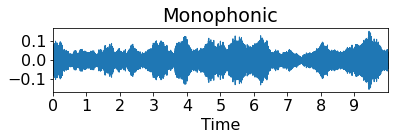

In [37]:
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load(
    "/Users/kvarada/MDS/data/genres/classical/classical.00001.wav", duration=10
)
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title("Monophonic")

In [38]:
import IPython.display

IPython.display.Audio(y, rate=sr)

- I have taken a subset of the above dataset with genres and stored it in `music_genres_small`
    - blues
    - classical
    - pop
    - rock


- Let's extract some domain-specific features called [MFCC features](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) from the above subset and store it as a CSV. 

In [39]:
data = {}
import glob
import ntpath

In [40]:
data_dir = "/Users/kvarada/MDS/data/music_genres_small/"
raw_audio_X = np.empty(shape=(400, 1))
raw_audio_y = []
row_ind = 0

for audio_file in glob.glob(data_dir + r"*/*.wav"):
    y, sr = librosa.load(audio_file, mono=True, duration=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    filename = ntpath.basename(audio_file)
    label = filename.split(".")[0]

    data.setdefault("audio_file", []).append(filename)
    data.setdefault("label", []).append(label)
    data.setdefault("chroma_stft", []).append(np.mean(chroma_stft))
    data.setdefault("spec_cent", []).append(np.mean(spec_cent))
    data.setdefault("spec_bw", []).append(np.mean(spec_bw))
    data.setdefault("rolloff", []).append(np.mean(rolloff))
    data.setdefault("zcr", []).append(np.mean(zcr))

    # Get mfcc features
    feat_prefix = "mfcc"
    ind = 1
    for feat in mfcc:
        key = feat_prefix + str(ind)
        data.setdefault(key, []).append(np.mean(feat))
        ind += 1
    try:
        raw_audio_X[row_ind] = np.mean(y)
        raw_audio_y.append(label)
    except:
        print("Broadcasting problem with file %s" % (audio_file))
    row_ind += 1

df = pd.DataFrame(data)
df.to_csv("data/music_genre.csv", index=False)

- If we just pass raw audio data to an ML model. 
- We are just taking the mean of the audio time series which won't be much meaningful in each case. 

In [41]:
raw_audio_y = np.asarray(raw_audio_y)
raw_audio_y.shape
X_train, X_test, y_train, y_test = train_test_split(
    raw_audio_X, raw_audio_y, test_size=0.20, random_state=111
)
lr = LogisticRegression(solver="liblinear")
pd.DataFrame(cross_validate(lr, X_train, y_train, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.001557,0.000335,0.250000,0.261719
1,0.000747,0.000229,0.250000,0.261719
2,0.000719,0.000228,0.265625,0.257812
3,0.000707,0.000229,0.265625,0.257812
4,0.000695,0.000228,0.265625,0.257812


Let's try it with standard domain-specific MFCC features.

In [42]:
music_cvs_df = pd.read_csv("data/music_genre.csv")
music_cvs_df.columns
X = music_cvs_df.drop(columns=["audio_file", "label"])
y = music_cvs_df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=111
)
lr = LogisticRegression(solver="liblinear")
pd.DataFrame(cross_validate(lr, X_train, y_train, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.009541,0.001137,0.703125,0.917969
1,0.007268,0.000937,0.796875,0.902344
2,0.007582,0.000957,0.781250,0.894531
3,0.006776,0.000964,0.781250,0.894531
4,0.007220,0.000953,0.796875,0.898438


- Much better results with domain-specific features!! 
- You could improve it further with more careful feature engineering. 

## Summary

- Feature engineering is finding the useful representation of the data that can help us effectively solve our problem.  
- Non-linear regression (change of basis)
- Radial basis functions
- Importance of feature engineering in text data and audio data.   

### Feature engineering 

- The best features are application-dependent.
- It's hard to give general advice. But here are some guidelines. 
    - Ask the domain experts.
    - Go through academic papers in the discipline. 
    - Often have idea of right discretization/standardization/transformation.
    - If no domain expert, cross-validation will help.
- If you have lots of data, use deep learning methods. 

<blockquote>
    The algorithms we used are very standard for Kagglers ... We spent most of our efforts in feature engineering... <br>
- Xavier Conort, on winning the Flight Quest challenge on Kaggle    
</blockquote>    